In [1]:
!pip install seaborn

In [2]:
!pip install shap

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import shap

In [4]:
# Load the datasets
data_full = pd.read_csv('full_data_flightdelay.csv')

# Display the first few rows of the dataframe
data_full.tail()



,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
6489057,12,7,0,2300-2359,1,11,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489058,12,7,0,1800-1859,1,11,2,123,Hawaiian Airlines Inc.,1318,...,16,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489059,12,7,0,2000-2059,1,11,2,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489060,12,7,0,2100-2159,1,12,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489061,12,7,1,2100-2159,1,12,3,123,Hawaiian Airlines Inc.,1318,...,15,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21


In [5]:
# Take a random sample of the data (e.g., 10% of the data)
data_sample = data_full.sample(frac=0.01, random_state=42)

# Display the first few rows of the sampled dataframe
print("Sampled Data Full:")
print(data_sample.head())

# Check the size of the sampled data
print("Size of the sampled data:", data_sample.shape)

Sampled Data Full:
         MONTH  DAY_OF_WEEK  DEP_DEL15 DEP_TIME_BLK  DISTANCE_GROUP  \
984735       3            5          0    1500-1559               3   
4740332      9            7          0    2200-2259               5   
6361351     12            1          0    1900-1959               3   
4012189      8            3          0    1700-1759               6   
4789024      9            5          0    0800-0859               2   

         SEGMENT_NUMBER  CONCURRENT_FLIGHTS  NUMBER_OF_SEATS  \
984735                4                  27               69   
4740332               1                   7              128   
6361351               5                  15               76   
4012189               2                  22              276   
4789024               1                   3               76   

                   CARRIER_NAME  AIRPORT_FLIGHTS_MONTH  ...  PLANE_AGE  \
984735    Midwest Airline, Inc.                  11965  ...         11   
4740332  American Air

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import shap

# Define features
features = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 
            'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 
            'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 
            'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS', 
            'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE', 'LONGITUDE', 'PREVIOUS_AIRPORT', 
            'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']

# Prepare the data
X = data_sample[features]
y = data_sample['DEP_DEL15']

# Handle categorical variables
categorical_features = ['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Handle 'DEP_TIME_BLK' separately
X['DEP_TIME_BLK'] = X['DEP_TIME_BLK'].astype('category').cat.codes

# Make sure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values
X.dropna(inplace=True)
y = y[X.index]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



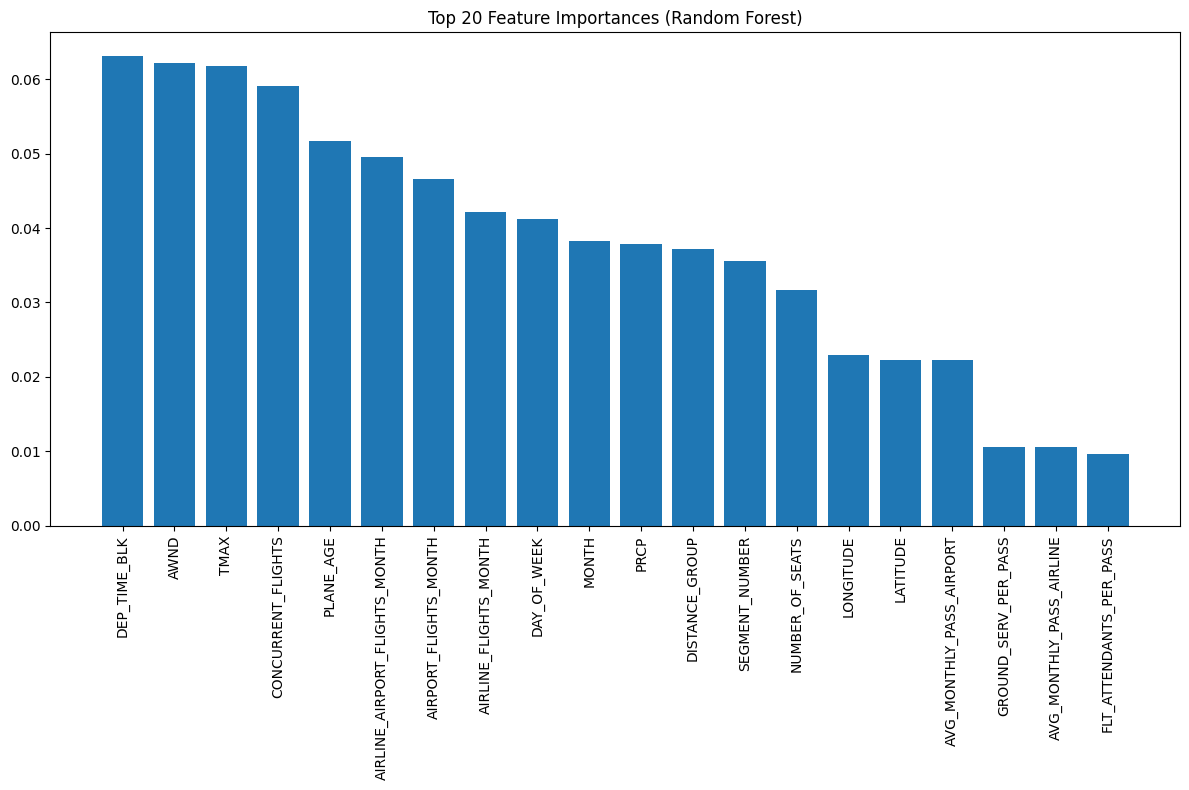

In [7]:
# 1. Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X.columns), reverse=True), columns=['Importance', 'Feature'])

plt.figure(figsize=(12, 8))
plt.bar(x=feature_imp['Feature'][:20], height=feature_imp['Importance'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


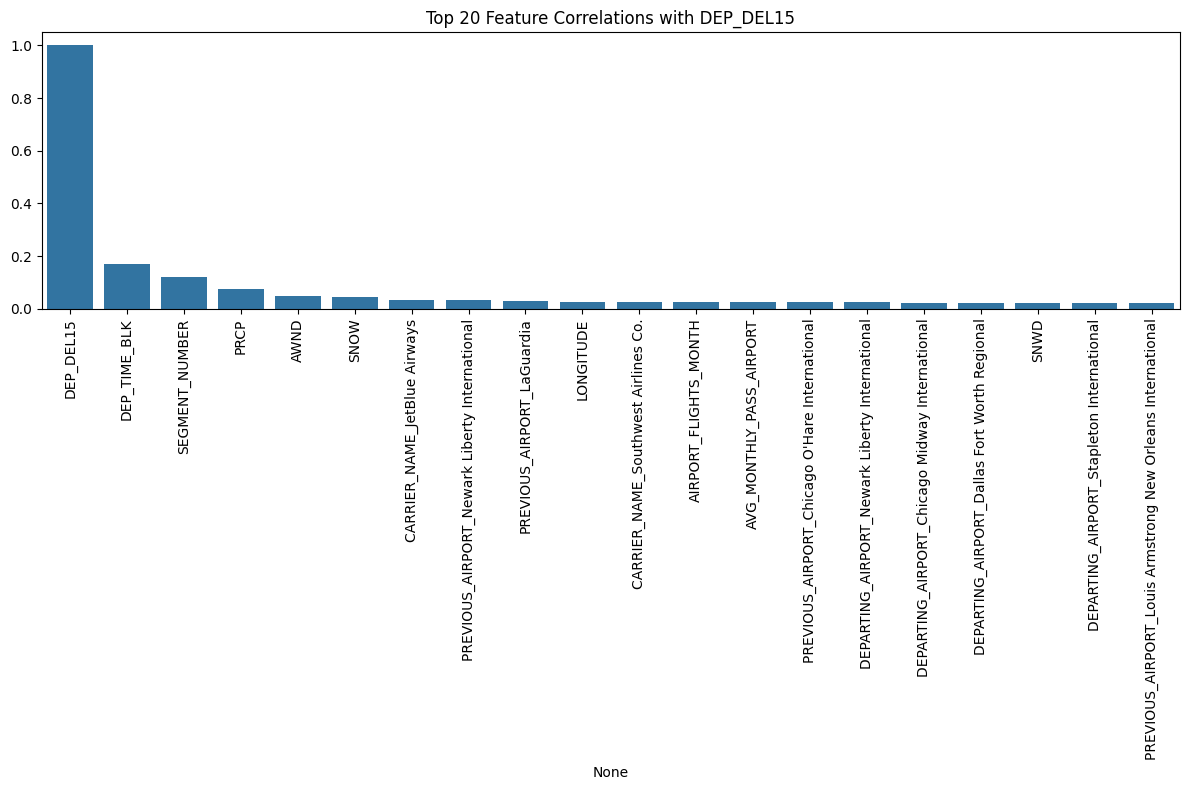

In [8]:
# 2. Correlation Analysis
corr = X.join(y).corr()['DEP_DEL15'].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=corr.index[:20], y=corr.values[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Feature Correlations with DEP_DEL15')
plt.tight_layout()
plt.show()

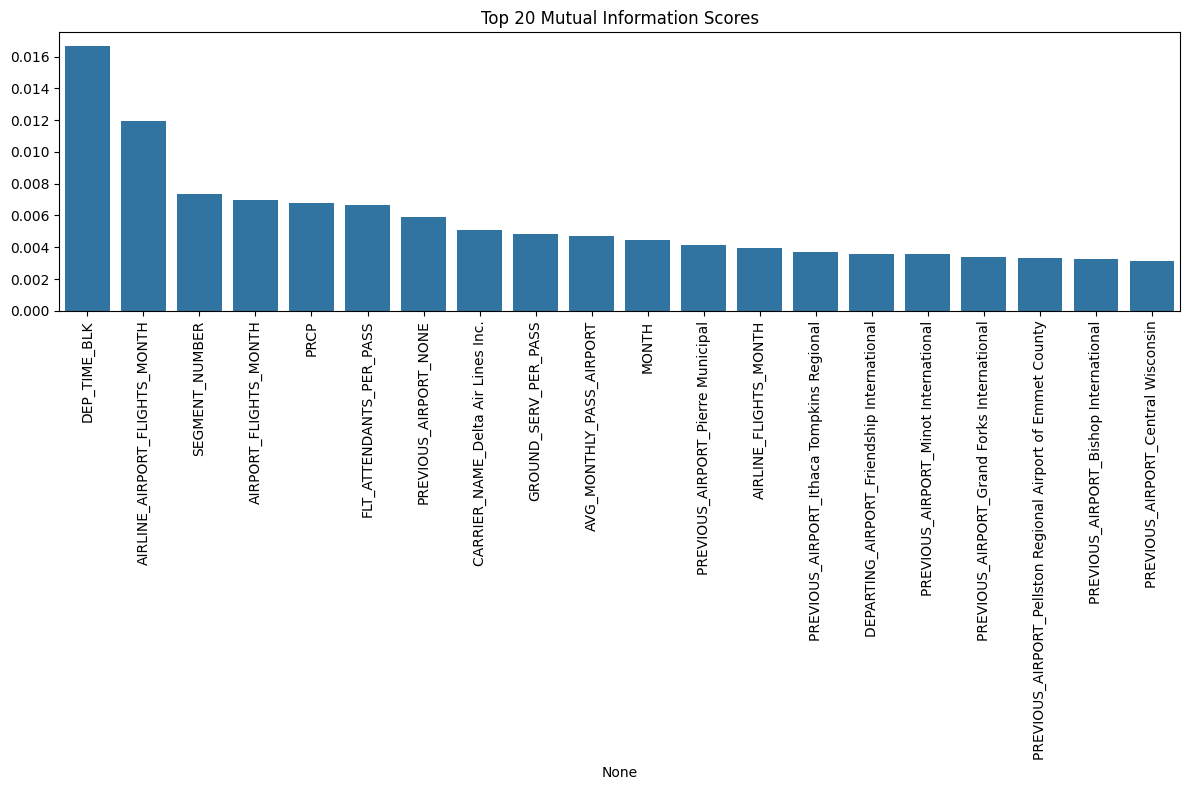

In [9]:
# 3. Mutual Information
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=mi_scores.index[:20], y=mi_scores.values[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Mutual Information Scores')
plt.tight_layout()
plt.show()

# This measures how much information the presence/absence of a feature contributes to making the correct prediction on the target variable.
# Interpretation:

# Values are always non-negative.
# Higher values indicate the feature provides more information about the target.
# A value of 0 means the feature and target are independent.
# Features with higher MI scores are more important for predicting delays.

In [ ]:
# 4. Permutation Importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_imp = pd.DataFrame(
    {'Importance': result.importances_mean, 'Feature': X.columns}
).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Importance', data=perm_imp.head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Permutation Importance')
plt.tight_layout()
plt.show()

# This shows how much the model performance decreases when a feature is randomly shuffled.
# Interpretation:

# Higher values indicate more important features.
# If shuffling a feature causes a large increase in the model's error, that feature is important.
# Features with near-zero importance might not be contributing much to the model's predictions.




In [ ]:
# 5. SHAP Values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)

# SHAP values show the impact of having a certain value for a feature in comparison to the prediction we'd make if that feature took some baseline value.
# Interpretation:

# Features are ordered by importance from top to bottom.
# The color shows whether that feature value had a positive (red) or negative (blue) impact on the prediction.
# The x-axis shows the SHAP value (impact on model output).
# Wider spread of SHAP values indicates a more important feature.